Starting public transport network optimization...
Created grid network with 16 stations
Generated demand matrix with 1032 passenger trips
Generated 384 candidate lines

Starting optimization algorithm...
Optimization complete! Total cost: 333018.62 (Operational: 11247.50, Waiting: 321771.12)

Public Transport Network Optimization Summary
Total candidate lines: 384
Active lines (frequency ≥ 0.5): 384
Total cost: 333018.62 per hour
  - Operational cost: 11247.50 per hour
  - Waiting cost: 321771.12 per hour
Total vehicle hours used: 149.97 hours/hour
Fleet utilization: 100.0%
Station coverage: 16/16 stations (100.0%)

Active line details:
 1. ['S0', 'S4', 'S8'] | Frequency: 10.0 veh/hr | Length: 2 km | Cost: 501.0
 2. ['S0', 'S4', 'S8', 'S12'] | Frequency: 10.0 veh/hr | Length: 3 km | Cost: 514.9
 3. ['S1', 'S0', 'S4', 'S8'] | Frequency: 10.0 veh/hr | Length: 3 km | Cost: 528.8
 4. ['S1', 'S5', 'S4', 'S8'] | Frequency: 10.0 veh/hr | Length: 3 km | Cost: 518.6
 5. ['S4', 'S8'] | Frequency

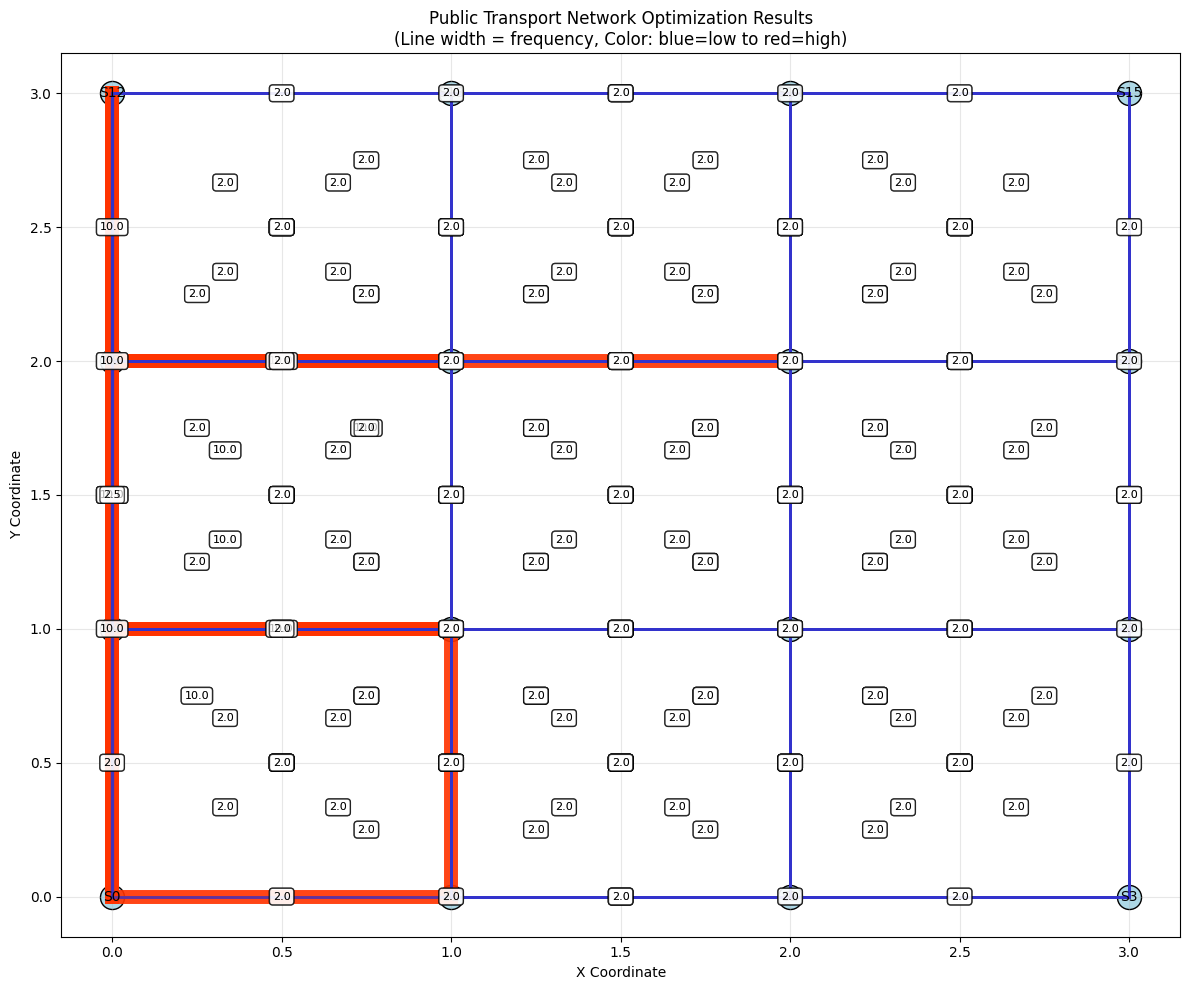


Optimization complete!


In [4]:
"""
Public Transport Network Optimization System
Pure Python implementation without complex dependencies
Author: LXD
Date: 2024
"""

import math
import random
import heapq
from collections import defaultdict, deque
import matplotlib.pyplot as plt

class PublicTransportOptimizer:
    """
    Simplified public transport network optimizer
    Uses basic Python without complex scientific computing libraries
    """
    
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.stations = []
        self.distances = {}
        self.demand_matrix = None
        self.params = {}
        self.solution = None
        
    def create_grid_network(self):
        """Create a grid-shaped transport network"""
        self.stations = []
        station_id = 0
        
        # Create grid stations
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                station_name = f"S{station_id}"
                self.stations.append({
                    'id': station_id,
                    'name': station_name,
                    'x': j,
                    'y': i
                })
                station_id += 1
                
        # Calculate distances between stations (Manhattan distance)
        self.distances = {}
        for i, s1 in enumerate(self.stations):
            for j, s2 in enumerate(self.stations):
                if i != j:
                    dist = abs(s1['x'] - s2['x']) + abs(s1['y'] - s2['y'])
                    self.distances[(i, j)] = dist
                    
        print(f"Created grid network with {len(self.stations)} stations")
        return self.stations
    
    def generate_demand(self, max_demand=100):
        """Generate random passenger demand"""
        n = len(self.stations)
        self.demand_matrix = [[0] * n for _ in range(n)]
        
        # Assign demand to random OD pairs
        num_pairs = min(n * (n-1) // 4, 20)
        
        for _ in range(num_pairs):
            i, j = random.sample(range(n), 2)
            self.demand_matrix[i][j] = random.randint(10, max_demand)
            
        total_demand = sum(sum(row) for row in self.demand_matrix)
        print(f"Generated demand matrix with {total_demand} passenger trips")
        return self.demand_matrix
    
    def set_parameters(self, params=None):
        """Set optimization parameters"""
        default_params = {
            'f_min': 2,      # Minimum frequency (vehicles/hour)
            'f_max': 10,     # Maximum frequency
            'c_wait': 30,    # Passenger waiting time cost
            'c_op': 5,       # Operational cost per km
            'theta': 0.5,    # Waiting time coefficient
            'B': 200,        # Fleet size constraint
            'min_coverage': 0.8  # Minimum station coverage
        }
        
        if params:
            for key, value in params.items():
                if key in default_params:
                    default_params[key] = value
                    
        self.params = default_params
        return self.params
    
    def find_shortest_paths(self, start, max_length=5):
        """Find short paths from start station using BFS"""
        paths = []
        queue = deque([(start, [start])])
        
        while queue:
            current, path = queue.popleft()
            if len(path) > 1 and len(path) <= max_length:
                paths.append(path[:])
                
            if len(path) < max_length:
                # Find adjacent stations (Manhattan distance = 1)
                for i, station in enumerate(self.stations):
                    if i not in path and self.distances.get((current, i), float('inf')) == 1:
                        queue.append((i, path + [i]))
                        
        return paths
    
    def generate_candidate_lines(self, max_line_length=4):
        """Generate candidate bus lines"""
        self.candidate_lines = []
        
        # Generate short paths for each station
        for i in range(len(self.stations)):
            paths = self.find_shortest_paths(i, max_line_length)
            self.candidate_lines.extend(paths)
            
        # Remove duplicates
        unique_lines = []
        for line in self.candidate_lines:
            if line not in unique_lines and len(line) > 1:
                unique_lines.append(line)
                
        self.candidate_lines = unique_lines
        print(f"Generated {len(self.candidate_lines)} candidate lines")
        return self.candidate_lines
    
    def evaluate_line_cost(self, line, frequency):
        """Evaluate cost for a single line"""
        if frequency == 0:
            return 0, 0
            
        # Calculate line length
        line_length = 0
        for i in range(len(line)-1):
            line_length += self.distances.get((line[i], line[i+1]), 0)
            
        # Operational cost
        op_cost = frequency * line_length * self.params['c_op']
        
        # Waiting time cost (simplified calculation)
        wait_cost = 0
        for station in line:
            # Calculate demand passing through this station
            station_demand = 0
            for i in range(len(self.demand_matrix)):
                for j in range(len(self.demand_matrix)):
                    if i == station or j == station:
                        station_demand += self.demand_matrix[i][j]
            
            if frequency > 0:
                wait_time = self.params['theta'] / frequency
                wait_cost += station_demand * wait_time * self.params['c_wait'] / len(line)
                
        return op_cost, wait_cost
    
    def greedy_optimize(self):
        """Optimize line frequencies using greedy algorithm"""
        n_lines = len(self.candidate_lines)
        
        # Initialize frequencies
        frequencies = [self.params['f_min']] * n_lines
        total_vehicle_hours = 0
        
        # Calculate base cost for each line
        line_costs = []
        for i, line in enumerate(self.candidate_lines):
            op_cost, wait_cost = self.evaluate_line_cost(line, frequencies[i])
            line_costs.append((i, op_cost + wait_cost, op_cost, wait_cost))
        
        # Sort by cost (highest cost first for optimization)
        line_costs.sort(key=lambda x: x[1], reverse=True)
        
        # Greedy optimization: incrementally increase frequency for high-value lines
        improvement = True
        while improvement and total_vehicle_hours < self.params['B']:
            improvement = False
            
            for i, _, _, _ in line_costs:
                if frequencies[i] < self.params['f_max']:
                    # Try increasing frequency
                    new_frequencies = frequencies[:]
                    new_frequencies[i] += 0.5  # Small increment
                    
                    # Calculate new vehicle hours
                    new_vehicle_hours = 0
                    for j, line in enumerate(self.candidate_lines):
                        line_time = 0
                        for k in range(len(line)-1):
                            line_time += 2  # Assume 2 minutes per segment
                        new_vehicle_hours += new_frequencies[j] * line_time * 2 / 60  # Convert to hours
                    
                    if new_vehicle_hours <= self.params['B']:
                        # Calculate new total cost
                        new_total_cost = 0
                        for j, line in enumerate(self.candidate_lines):
                            op_cost, wait_cost = self.evaluate_line_cost(line, new_frequencies[j])
                            new_total_cost += op_cost + wait_cost
                        
                        # Calculate old total cost
                        old_total_cost = 0
                        for j, line in enumerate(self.candidate_lines):
                            op_cost, wait_cost = self.evaluate_line_cost(line, frequencies[j])
                            old_total_cost += op_cost + wait_cost
                        
                        # Accept change if cost decreases
                        if new_total_cost < old_total_cost:
                            frequencies = new_frequencies
                            total_vehicle_hours = new_vehicle_hours
                            improvement = True
                            break
        
        # Create solution dictionary
        self.solution = {}
        total_cost = 0
        total_op_cost = 0
        total_wait_cost = 0
        
        for i, line in enumerate(self.candidate_lines):
            if frequencies[i] > 0.1:  # Only keep meaningful lines
                op_cost, wait_cost = self.evaluate_line_cost(line, frequencies[i])
                self.solution[tuple(line)] = {
                    'frequency': frequencies[i],
                    'op_cost': op_cost,
                    'wait_cost': wait_cost
                }
                total_cost += op_cost + wait_cost
                total_op_cost += op_cost
                total_wait_cost += wait_cost
                
        print(f"Optimization complete! Total cost: {total_cost:.2f} (Operational: {total_op_cost:.2f}, Waiting: {total_wait_cost:.2f})")
        return self.solution
    
    def visualize_network(self, min_frequency=0.5):
        """Visualize optimization results"""
        if not self.solution:
            print("No solution available")
            return
            
        plt.figure(figsize=(12, 10))
        
        # Plot stations
        xs = [s['x'] for s in self.stations]
        ys = [s['y'] for s in self.stations]
        plt.scatter(xs, ys, s=300, c='lightblue', edgecolors='black')
        
        # Add station labels
        for s in self.stations:
            plt.text(s['x'], s['y'], s['name'], 
                    ha='center', va='center', fontsize=10)
        
        # Plot lines
        for line, data in self.solution.items():
            if data['frequency'] >= min_frequency:
                freq = data['frequency']
                linewidth = max(1, freq)
                
                # Set color based on frequency
                color_value = min(1.0, freq / self.params['f_max'])
                color = (color_value, 0.2, 1-color_value)
                
                # Draw line
                x_coords = [self.stations[i]['x'] for i in line]
                y_coords = [self.stations[i]['y'] for i in line]
                
                plt.plot(x_coords, y_coords, linewidth=linewidth, 
                        color=color, alpha=0.7)
                
                # Add frequency label
                if len(line) > 1:
                    mid_x = sum(x_coords) / len(x_coords)
                    mid_y = sum(y_coords) / len(y_coords)
                    
                    plt.text(mid_x, mid_y, f"{freq:.1f}", 
                            fontsize=8, ha='center', va='center',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
        
        plt.title("Public Transport Network Optimization Results\n(Line width = frequency, Color: blue=low to red=high)")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def print_solution_summary(self, min_frequency=0.5):
        """Print solution summary"""
        if not self.solution:
            print("No solution available")
            return
            
        active_lines = {line: data for line, data in self.solution.items() 
                       if data['frequency'] >= min_frequency}
        
        print("\n" + "="*60)
        print("Public Transport Network Optimization Summary")
        print("="*60)
        print(f"Total candidate lines: {len(self.candidate_lines)}")
        print(f"Active lines (frequency ≥ {min_frequency}): {len(active_lines)}")
        
        # Calculate total costs
        total_cost = 0
        total_op_cost = 0
        total_wait_cost = 0
        total_vehicle_hours = 0
        
        for line, data in self.solution.items():
            if data['frequency'] >= min_frequency:
                total_cost += data['op_cost'] + data['wait_cost']
                total_op_cost += data['op_cost']
                total_wait_cost += data['wait_cost']
                
                # Calculate vehicle hours
                line_time = 0
                for i in range(len(line)-1):
                    line_time += 2  # Assume 2 minutes per segment
                total_vehicle_hours += data['frequency'] * line_time * 2 / 60  # Round trip, convert to hours
        
        print(f"Total cost: {total_cost:.2f} per hour")
        print(f"  - Operational cost: {total_op_cost:.2f} per hour")
        print(f"  - Waiting cost: {total_wait_cost:.2f} per hour")
        print(f"Total vehicle hours used: {total_vehicle_hours:.2f} hours/hour")
        print(f"Fleet utilization: {total_vehicle_hours/self.params['B']*100:.1f}%")
        
        # Calculate station coverage
        stations_covered = set()
        for line in active_lines:
            stations_covered.update(line)
        
        coverage_rate = len(stations_covered) / len(self.stations) * 100
        print(f"Station coverage: {len(stations_covered)}/{len(self.stations)} stations ({coverage_rate:.1f}%)")
        
        # Print active line details
        print("\nActive line details:")
        sorted_lines = sorted(active_lines.items(), 
                            key=lambda x: x[1]['frequency'], reverse=True)
        
        for i, (line, data) in enumerate(sorted_lines, 1):
            line_length = 0
            for j in range(len(line)-1):
                line_length += self.distances.get((line[j], line[j+1]), 0)
                
            station_names = [self.stations[idx]['name'] for idx in line]
            print(f"{i:2d}. {station_names} | Frequency: {data['frequency']:.1f} veh/hr | "
                  f"Length: {line_length:.0f} km | Cost: {data['op_cost']+data['wait_cost']:.1f}")
        
        # Evaluate demand satisfaction
        total_demand = sum(sum(row) for row in self.demand_matrix)
        satisfied_demand = 0
        
        # Simplified estimation: assume demand is satisfied if both stations are on the same line
        for i in range(len(self.demand_matrix)):
            for j in range(len(self.demand_matrix)):
                if self.demand_matrix[i][j] > 0:
                    # Check if any line connects i and j
                    for line in active_lines:
                        if i in line and j in line:
                            satisfied_demand += self.demand_matrix[i][j]
                            break
        
        if total_demand > 0:
            demand_satisfaction = satisfied_demand / total_demand * 100
            print(f"\nDemand satisfaction rate: {satisfied_demand}/{total_demand} ({demand_satisfaction:.1f}%)")

# Main program
def main():
    """Main function - run public transport optimization"""
    print("Starting public transport network optimization...")
    
    # Create optimizer instance
    optimizer = PublicTransportOptimizer(grid_size=4)
    
    # Create grid network (4x4 = 16 stations)
    stations = optimizer.create_grid_network()
    
    # Generate passenger demand
    optimizer.generate_demand(max_demand=100)
    
    # Set parameters
    params = {
        'f_min': 2,      # Minimum frequency (vehicles/hour)
        'f_max': 10,     # Maximum frequency
        'c_wait': 30,    # Passenger waiting time cost
        'c_op': 5,       # Operational cost per km
        'B': 150,        # Fleet size constraint
    }
    optimizer.set_parameters(params)
    
    # Generate candidate lines
    optimizer.generate_candidate_lines(max_line_length=4)
    
    # Run optimization
    print("\nStarting optimization algorithm...")
    optimizer.greedy_optimize()
    
    # Display results
    optimizer.print_solution_summary(min_frequency=0.5)
    optimizer.visualize_network(min_frequency=0.5)
    
    print("\nOptimization complete!")

# Run example
if __name__ == "__main__":
    main()